In [1]:
#IN google colab install abtem and pycu for gpu acceleration:
#!pip install abtem
#!pip install pycu

%matplotlib inline

from abtem import __version__
print('current version:', __version__)

import matplotlib.pyplot as plt
from ase.io import read
from ase.build import mx2

from abtem import *
from abtem.structures import orthogonalize_cell

from ase.spacegroup import crystal

from ase.visualize import view

from abtem.transfer import scherzer_defocus
import numpy as np

import matplotlib.pyplot as plt

from abtem.utils import fft_shift
from abtem.aperture import DeviatedAnularAperture
from abtem.aperture import DeviatedAperture
import scipy.constants as c

from collections import defaultdict

from abtem.transfer import cartesian2polar

current version: 1.0.0beta27


In [2]:
def imshow(X, *args, **kwargs): # it seems so that reciprocal arrays (phi or alpha or result of evaluating ctf or aperture) are transformed so that it is neccessary to firstly use fftshift and then mirror the values along axis=0. In arrays which are in direct space (probe image) via probe.build().intensity().array[0] it suffices only to morror the image along axis=0. 
    return plt.imshow(X=np.flip(X,axis=0),*args, **kwargs)
    #return plt.imshow(X=np.swapaxes(X,0,1),*args, **kwargs)
    #return plt.imshow(X=np.swapaxes(np.flip(X,axis=0),0,1),*args, **kwargs)

# SrTiO$_3$

We build an atomic structure of MoS2 with ASE. Since abTEM requires an orthogonal we make the cell orthogonal. We also need to repeat the structure, so the probe fits inside the cell.

<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

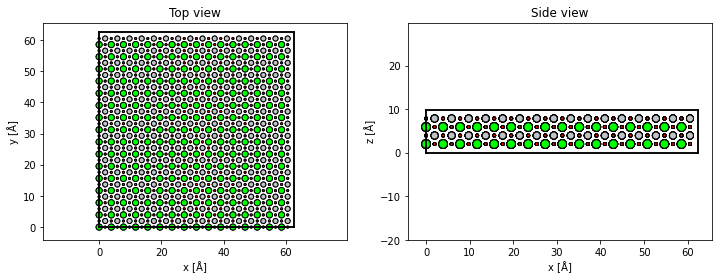

In [3]:
atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
srtio3 = crystal(['Sr','Ti','O'], atom_pos, spacegroup=221, cellpar=3.905, size=(1, 1, 2))
atoms = srtio3

repetitions = (16, 16, 1)

atoms = orthogonalize_cell(atoms)

atoms *= repetitions

atoms.center(vacuum=2, axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

In [4]:
#view(atoms)

In [5]:
print(f"Simulation cell: {atoms.cell}")

Simulation cell: Cell([62.48, 62.48, 9.8575])


We create and calculate the electrostatic potential.

In [6]:
gpts=512
potential = Potential(atoms, 
                      gpts=gpts,
                      projection='finite', 
                      slice_thickness=1, 
                      parametrization='kirkland')

potential = potential.build()

10

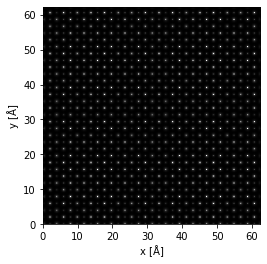

In [7]:
potential.project().show()
len(potential)

In [8]:
print(f"Real space sampling: {potential.sampling}")

Real space sampling: (0.12203125, 0.12203125)


In [9]:
#def custom_cartesian2polar(cartesian):
#    cartesian = defaultdict(lambda: 0, cartesian)
#    max_order = 5
#    polar = dict()
#    for n in range(1,max_order+1):
#        for s in range(0,n+2):
#            m = 2*s-n-1
#            if m < 0:
#                continue
#
#            modulus_name="C"+str(n)+str(m)
#            Ca = modulus_name + "a"
#            Cb = modulus_name + "b"
#            if m != 0:
#                argument_name="phi"+str(n)+str(m)
#                polar[modulus_name] = np.sqrt(cartesian[Ca]**2 + cartesian[Cb]**2)
#                polar[argument_name] = np.arctan2(cartesian[Cb],cartesian[Ca])/m
#            else:
#                polar[modulus_name] = cartesian[modulus_name]
#    return(polar)

In [10]:
#Functions for calculation of abberation coefficients for deviated probe and transformed probe using (C1,A1,...) noteation

In [11]:
def m2A(m):
    return(m/1e-10)

def Haider2Krivanek(C1,A1,C3,B2,A2=0+0*1j):
    cartesian = dict()
    
        
    #C1 - C10
    #A1 - C12
    #B2 - 1/3*np.conjugated(C21) !!
    #A2 - # it is zero
    #C3 - C30
    
    cartesian['C10']  = m2A(C1.real)
    cartesian['C12a'] = m2A(A1.real)
    cartesian['C12b'] = m2A(A1.imag)
    cartesian['C21a'] = m2A(3*B2.conjugate().real) # there should be conjugation
    cartesian['C21b'] = m2A(3*B2.conjugate().imag) # there should be conjugation
    cartesian['C30']  = m2A(C3)
    
    cartesian['C23a']  = m2A(A2.real)
    cartesian['C23b']  = m2A(A2.imag)
    return(cartesian)

def get_coeffs(C1,A1,C3,B2=0*1j,A2=0+0*1j): #parameters in argumentC1,A1,.. are original values of aberations in [m]
    A0=0+0*1j
    cartesian = Haider2Krivanek(C1,A1,C3,B2,A2)
    return(m2A(A0).real,m2A(A0).imag,cartesian2polar(cartesian)) #returning in angstrems

def get_transformed_coeffs(C1,A1,C3,delta): #parameters in argument C1, A1,.. are original values of aberations in [m]
    A0_new = C1*delta+A1*delta.conjugate()+C3*delta**2*delta.conjugate()
    C1_new = C1+2*C3*delta*delta.conjugate() #C1_new,A1_new,.. are values of aberations after transformation of variables into the ones with shifted aperture
    A1_new = A1+C3*delta**2
    B2_new = C3*delta.conjugate()# according to theory there should be C3*delta.conjugate() 
    #A2_new =  # it is zero
    C3_new = C3 

    cartesian = Haider2Krivanek(C1_new,A1_new,C3_new,B2_new)

    return(m2A(A0_new).real,m2A(A0_new).imag,cartesian2polar(cartesian)) #returning in angstrems

_, _, aberations_dict = get_transformed_coeffs(C1=0,A1=0,C3=1.9e-3,delta=0+0*1j)



energy=200e3
phi_star=energy*(1-c.elementary_charge*energy/2/c.m_e/c.c**2)

#temporal coherrence
Cc=1.61e-3/1e-10 # In Angstrem
focal_spread=Cc*(0.6/200e3)

#spatial coherrence
reduced_brightness=1e8 
d=1*2*1e-10 # from graph below with C3=0 
I=0.2e-9
alphaa=np.sqrt(4*I/np.pi**2/d**2/reduced_brightness/phi_star)
beta=1/np.e*alphaa*1e3#1/e of angle distribution in [mrad]
angular_spread=beta

defocus_0=scherzer_defocus(Cs=aberations_dict["C30"],energy=energy)        

In [12]:
semiangle_cutoff=9.5

In [13]:
probe = Probe(energy=energy, semiangle_cutoff=semiangle_cutoff, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"], angular_spread=angular_spread,focal_spread=focal_spread)

To run this simulation using PRISM instead of the standard multislice algorithm, uncomment the cell below. Note that while PRISM may be up to a 1000 times faster than multislice for large structures, the performance is fairly similar for small simulations like this.

In [14]:
#probe = SMatrix(energy=energy, semiangle_cutoff=11.3, expansion_cutoff=20, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"])
#probe = SMatrix(energy=energy, semiangle_cutoff=9.5, expansion_cutoff=20, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"],angular_spread=angular_spread,focal_spread=focal_spread)
#_, _, aberations_dict = get_transformed_coeffs(C1=-defocus_0*1e-10,A1=0,C3=1.9e-3,delta=0e-3+0*1j) 
#probe.ctf.set_parameters(aberations_dict)

In [15]:
print("defocus_0: ",defocus_0)
print("angular_spread: ",angular_spread)
print("focal_spread: ",focal_spread)

defocus_0:  845.4355085066284
angular_spread:  4.129003900122874
focal_spread:  48.300000000000004


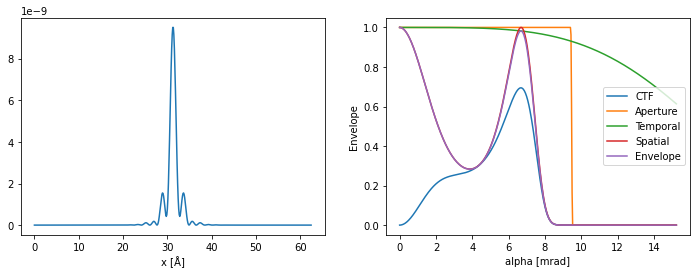

In [16]:
probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

probe.profile().show(ax=ax1);

probe.ctf.show(ax=ax2);

In [17]:
#Calculate radial intensity of probe and cumulative radial intensity for estimate of probe diameter (at 50% of current)

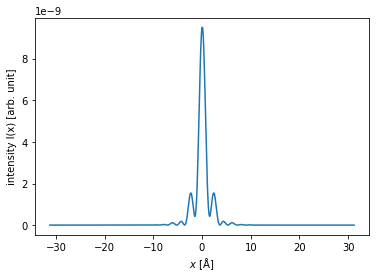

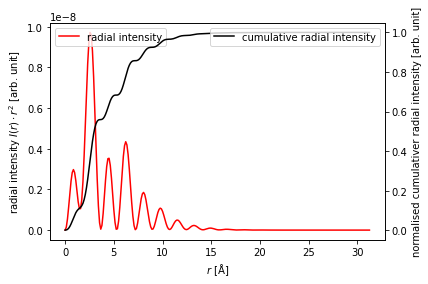

In [18]:
calibration=probe.profile().calibrations[0]
y = probe.profile().array #it is already intensity
x = np.linspace(calibration.offset, calibration.offset + len(y) * calibration.sampling, len(y))
x = x-calibration.sampling*len(y)/2

y_cropped = y[x >= 0]
x_cropped = x[x >= 0]

plt.plot(x,y)
plt.xlabel(r"$x$ [$\mathrm{\AA}$]")
plt.ylabel(r"intensity I(x) [arb. unit]")

radial_intensity = y_cropped * x_cropped**2 

fig, ax1 = plt.subplots() 

plt.plot(x_cropped,radial_intensity,"r",label="radial intensity")

plt.xlabel(r"$r$ [$\mathrm{\AA}$]")
plt.ylabel(r"radial intensity $I(r) \cdot r^2$ [arb. unit]")

ax1.legend(loc=2)

ax2=ax1.twinx()

cumulative_radial_intensity = np.cumsum(radial_intensity)/radial_intensity.sum() #relaying on the fact that sampling in position is equidistant
plt.plot(x_cropped,cumulative_radial_intensity,"k",label="cumulative radial intensity")
plt.ylabel(r"normalised cumulativer radial intensity [arb. unit]")
ax2.legend(loc=1)
plt.show()

In [19]:
#Show probe profile via abtem method

(<AxesSubplot:xlabel='x [Å]'>, <matplotlib.lines.Line2D at 0x7fe7080a6ee0>)

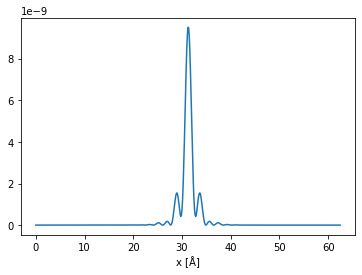

In [20]:
probe.profile().show()

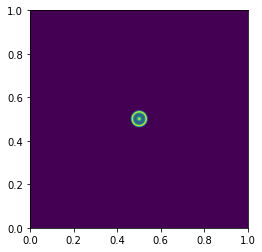

In [21]:
alpha, phi = probe.get_scattering_angles()
imshow(np.absolute(fft_shift(probe.ctf.evaluate_spatial_envelope(alpha,phi),np.array([gpts/2,gpts/2]))),extent=(0,1,0,1))

We create a `FlexibleAnnularDetector` detector which will allow us to choose the integration limits after the multislice simulation.

In [22]:
detector = FlexibleAnnularDetector()

In [23]:
#Generating probes with shifted anular detector, anular detector without spokes and with only circular aperture 

In [24]:
nrows = 4
ncols = 4

C3 = 1.9e-3#1.9e-3# in meters
defocus_0 = defocus_0#1000#-1000#845#1000# in angstrem
#A1 = 600e-10#500e-10#500e-10#100e-10#1000e-10#*(1+1j) in meters

delta_divisions = 7
#delta_semiangle = semiangle_cutoff
delta_semiangle =  2 # in mrad
delta_max=3e-3+1e-3j

spoke_thickness=1
spokes=3

index = 0
for A1 in np.linspace(-600e-10,600e-10,11):
    for delta in delta_max*np.linspace(-1,1,delta_divisions):
        name="{index:05d}-A1_{A1:.1f}-deltax_{deltax:.1f}-deltay_{deltay:.1f}".format(index=index,A1=A1/1e-10,deltax=delta.real*1e3,deltay=delta.imag*1e3)
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 15))
        aperture = DeviatedAnularAperture(aperture_angle=semiangle_cutoff,x_0=0,y_0=0,inner_aperture_angle=semiangle_cutoff/2,spoke_thickness=spoke_thickness,spokes=spokes)
        probe_transformed = Probe(energy=energy, aperture=aperture, semiangle_cutoff=semiangle_cutoff, rolloff=0.1)#, angular_spread=angular_spread,focal_spread=focal_spread)
        probe_transformed.grid.match(potential)

        C01a, C01b, aberations_dict_transformed = get_transformed_coeffs(C1=-defocus_0*1e-10,A1=A1,C3=C3,delta=delta) #arguments in [m] and returns in angstrem
        probe_transformed.ctf.set_parameters(aberations_dict_transformed)

        C01 = np.array([C01b,C01a]) # I suppose that the coefficients should be interchanged so that x is C01b and y is C01a 
        print(C01)
        start = np.array([0,0]) + C01 # it is supposed to be in angstrems
        end = np.array((potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])) + C01
        gridscan = GridScan(start=start, end=end, sampling=probe_transformed.ctf.nyquist_sampling * .9)
        measurement = probe_transformed.scan(gridscan, detector, potential)
        

        probe_transformed.show(ax=ax[0,0])
        ax[0,0].set_title("transformed")
        ax[0,0].set_xlabel("y [$\AA$]") #intentionally swapped
        ax[0,0].set_ylabel("x [$\AA$]")
        ax[1,0].imshow(np.flip(np.absolute(fft_shift(probe_transformed.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,gpts/2]))),axis=0),extent=(-1,1,-1,1),interpolation="none")
        ax[1,0].plot(0,0,"rx",markersize=12)
        ax[1,0].set_xlabel("x")
        ax[1,0].set_ylabel("y")
        im=ax[2,0].imshow(np.flip(np.absolute(fft_shift(probe_transformed.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,gpts/2])))*np.angle(fft_shift(probe_transformed.ctf.evaluate(alpha,phi),np.array([gpts/2,gpts/2]))),axis=0),extent=(-1,1,-1,1),interpolation="none")
        fig.colorbar(im,ax=ax[2,0])
        ax[2,0].set_xlabel("x")
        ax[2,0].set_ylabel("y")
        measurement.integrate(50,80).interpolate(0.05).show(ax=ax[3,0])
        ax[3,0].set_xlabel("y")
        ax[3,0].set_ylabel("x")
        
        
        #################

        aperture = DeviatedAnularAperture(aperture_angle=semiangle_cutoff,x_0=delta.real*1e3,y_0=delta.imag*1e3,inner_aperture_angle=semiangle_cutoff/2,spoke_thickness=spoke_thickness,spokes=spokes)

        probe_deviated = Probe(aperture=aperture, energy=energy, semiangle_cutoff=semiangle_cutoff+np.absolute(delta), rolloff=0.1)#, angular_spread=angular_spread,focal_spread=focal_spread)
        probe_deviated.grid.match(potential)

        _, _, aberations_dict_deviated = get_coeffs(C1=-defocus_0*1e-10,A1=A1,C3=C3,B2=(0+0j)*1e-6,A2=(0+0j)*30e-6) #arguments in [m] and returns in angstrem
        probe_deviated.ctf.set_parameters(aberations_dict_deviated)

        start = np.array([0,0]) # it is supposed to be in angstrems
        end = np.array((potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1]))
        gridscan = GridScan(start=start, end=end, sampling=probe_deviated.ctf.nyquist_sampling * .9)
        measurement = probe_deviated.scan(gridscan, detector, potential)

        probe_deviated.show(ax=ax[0,1])
        ax[0,1].set_title("deviated")
        ax[0,1].set_xlabel("y [$\AA$]") #intentionally swapped
        ax[0,1].set_ylabel("x [$\AA$]")
        ax[1,1].imshow(np.flip(np.absolute(fft_shift(probe_deviated.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,gpts/2]))),axis=0),extent=(-1,1,-1,1),interpolation="none")
        ax[1,1].plot(0,0,"rx",markersize=12)
        ax[1,1].set_xlabel("x")
        ax[1,1].set_ylabel("y")
        im=ax[2,1].imshow(np.flip(np.absolute(fft_shift(probe_deviated.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,gpts/2])))*np.angle(fft_shift(probe_deviated.ctf.evaluate(alpha,phi),np.array([gpts/2,gpts/2]))),axis=0),extent=(-1,1,-1,1),interpolation="none")
        fig.colorbar(im,ax=ax[2,1])
        ax[2,1].set_xlabel("x")
        ax[2,1].set_ylabel("y")
        measurement.integrate(50,80).interpolate(0.05).show(ax=ax[3,1])
        ax[3,1].set_xlabel("y")
        ax[3,1].set_ylabel("x")



        ################

        aperture = DeviatedAnularAperture(aperture_angle=semiangle_cutoff,x_0=delta.real*1e3,y_0=delta.imag*1e3,inner_aperture_angle=semiangle_cutoff/2,spoke_thickness=0,spokes=0)

        probe_deviated = Probe(aperture=aperture, energy=energy, semiangle_cutoff=semiangle_cutoff+np.absolute(delta), rolloff=0.1)#, angular_spread=angular_spread,focal_spread=focal_spread)
        probe_deviated.grid.match(potential)

        _, _, aberations_dict_deviated = get_coeffs(C1=-defocus_0*1e-10,A1=A1,C3=C3,B2=(0+0j)*1e-6,A2=(0+0j)*30e-6) #arguments in [m] and returns in angstrem
        probe_deviated.ctf.set_parameters(aberations_dict_deviated)

        start = np.array([0,0]) # it is supposed to be in angstrems
        end = np.array((potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1]))
        gridscan = GridScan(start=start, end=end, sampling=probe_deviated.ctf.nyquist_sampling * .9)
        measurement = probe_deviated.scan(gridscan, detector, potential)

        probe_deviated.show(ax=ax[0,2])
        ax[0,2].set_title("deviated")
        ax[0,2].set_xlabel("y [$\AA$]") #intentionally swapped
        ax[0,2].set_ylabel("x [$\AA$]")
        ax[1,2].imshow(np.flip(np.absolute(fft_shift(probe_deviated.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,gpts/2]))),axis=0),extent=(-1,1,-1,1),interpolation="none")
        ax[1,2].plot(0,0,"rx",markersize=12)
        ax[1,2].set_xlabel("x")
        ax[1,2].set_ylabel("y")
        im=ax[2,2].imshow(np.flip(np.absolute(fft_shift(probe_deviated.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,gpts/2])))*np.angle(fft_shift(probe_deviated.ctf.evaluate(alpha,phi),np.array([gpts/2,gpts/2]))),axis=0),extent=(-1,1,-1,1),interpolation="none")
        fig.colorbar(im,ax=ax[2,2])
        ax[2,2].set_xlabel("x")
        ax[2,2].set_ylabel("y")
        measurement.integrate(50,80).interpolate(0.05).show(ax=ax[3,2])
        ax[3,2].set_xlabel("y")
        ax[3,2].set_ylabel("x")

        ################

        aperture = DeviatedAnularAperture(aperture_angle=semiangle_cutoff,x_0=delta.real*1e3,y_0=delta.imag*1e3,inner_aperture_angle=0,spoke_thickness=0,spokes=0)

        probe_deviated = Probe(aperture=aperture, energy=energy, semiangle_cutoff=semiangle_cutoff+np.absolute(delta), rolloff=0.1)#, angular_spread=angular_spread,focal_spread=focal_spread)
        probe_deviated.grid.match(potential)

        _, _, aberations_dict_deviated = get_coeffs(C1=-defocus_0*1e-10,A1=A1,C3=C3,B2=(0+0j)*1e-6,A2=(0+0j)*30e-6) #arguments in [m] and returns in angstrem
        probe_deviated.ctf.set_parameters(aberations_dict_deviated)

        start = np.array([0,0]) # it is supposed to be in angstrems
        end = np.array((potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1]))
        gridscan = GridScan(start=start, end=end, sampling=probe_deviated.ctf.nyquist_sampling * .9)
        measurement = probe_deviated.scan(gridscan, detector, potential)

        probe_deviated.show(ax=ax[0,3])
        ax[0,3].set_title("deviated")
        ax[0,3].set_xlabel("y [$\AA$]") #intentionally swapped
        ax[0,3].set_ylabel("x [$\AA$]")
        ax[1,3].imshow(np.flip(np.absolute(fft_shift(probe_deviated.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,gpts/2]))),axis=0),extent=(-1,1,-1,1),interpolation="none")
        ax[1,3].plot(0,0,"rx",markersize=12)
        ax[1,3].set_xlabel("x")
        ax[1,3].set_ylabel("y")
        im=ax[2,3].imshow(np.flip(np.absolute(fft_shift(probe_deviated.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,gpts/2])))*np.angle(fft_shift(probe_deviated.ctf.evaluate(alpha,phi),np.array([gpts/2,gpts/2]))),axis=0),extent=(-1,1,-1,1),interpolation="none")
        fig.suptitle(name)
        fig.colorbar(im,ax=ax[2,3])
        ax[2,3].set_xlabel("x")
        ax[2,3].set_ylabel("y")
        measurement.integrate(50,80).interpolate(0.05).show(ax=ax[3,3])
        ax[3,3].set_xlabel("y")
        ax[3,3].set_ylabel("x")

        plt.savefig("figs/DeviatedAnularAperture/"+name+".pdf")
        index+=1
        
        print("end")
        plt.close()
        #plt.show()
        #break


[0.05543551 3.76630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.10732738 2.72198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.0747748 1.4243244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0. 0.]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.0747748 -1.4243244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.10732738 -2.72198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.05543551 -3.76630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.17543551 3.40630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.18732738 2.48198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.1147748 1.3043244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0. 0.]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.1147748 -1.3043244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.18732738 -2.48198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.17543551 -3.40630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.29543551 3.04630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.26732738 2.24198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.1547748 1.1843244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0. 0.]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.1547748 -1.1843244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.26732738 -2.24198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.29543551 -3.04630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.41543551 2.68630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.34732738 2.00198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.1947748 1.0643244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0. 0.]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.1947748 -1.0643244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.34732738 -2.00198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.41543551 -2.68630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.53543551 2.32630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.42732738 1.76198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.2347748 0.9443244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0. 0.]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.2347748 -0.9443244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.42732738 -1.76198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.53543551 -2.32630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.65543551 1.96630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.50732738 1.52198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.2747748 0.8243244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0. 0.]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.2747748 -0.8243244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.50732738 -1.52198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.65543551 -1.96630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.77543551 1.60630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.58732738 1.28198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.3147748 0.7043244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0. 0.]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.3147748 -0.7043244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.58732738 -1.28198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.77543551 -1.60630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.89543551 1.24630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.66732738 1.04198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.3547748 0.5843244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0. 0.]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.3547748 -0.5843244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.66732738 -1.04198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.89543551 -1.24630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[1.01543551 0.88630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.74732738 0.80198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.3947748 0.4643244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0. 0.]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.3947748 -0.4643244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.74732738 -0.80198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-1.01543551 -0.88630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[1.13543551 0.52630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.82732738 0.56198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.4347748 0.3443244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0. 0.]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.4347748 -0.3443244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.82732738 -0.56198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-1.13543551 -0.52630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[1.25543551 0.16630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.90732738 0.32198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0.4747748 0.2243244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[0. 0.]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.4747748 -0.2243244]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-0.90732738 -0.32198213]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end
[-1.25543551 -0.16630653]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

end


In [25]:
#Show transformed probe

{'C10': 256.56449149337163, 'C12': 1068.8316050716314, 'phi12': 0.18173967603571256, 'C21': 306954.3940066667, 'phi21': 0.38050637711236485, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}
[-1.78887102  1.52782246]


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fe677ee9e80>)

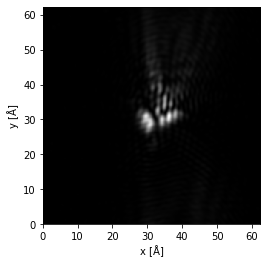

In [29]:
C3 = 1.9e-3#1.9e-3# in meters
defocus_0 = defocus_0#1000#-1000#845#1000# in angstrem
A1 = 600e-10#500e-10#500e-10#100e-10#1000e-10#*(1+1j) in meters

spoke_thickness=1
spokes=3
aperture = DeviatedAnularAperture(aperture_angle=semiangle_cutoff,x_0=0,y_0=0,inner_aperture_angle=semiangle_cutoff/2,spoke_thickness=spoke_thickness,spokes=spokes)
#aperture = None
probe_transformed = Probe(energy=energy, aperture=aperture, semiangle_cutoff=semiangle_cutoff, rolloff=0.1)#, angular_spread=angular_spread,focal_spread=focal_spread)
probe_transformed.grid.match(potential)

delta=5e-3+2e-3j
C01a, C01b, aberations_dict_transformed = get_transformed_coeffs(C1=-defocus_0*1e-10,A1=A1,C3=C3,delta=delta) #arguments in [m] and returns in angstrem
probe_transformed.ctf.set_parameters(aberations_dict_transformed)
print(probe_transformed.ctf.parameters)

C01 = np.array([C01b,C01a]) # I suppose that the coefficients should be interchanged so that x is C01b and y is C01a 
print(C01)
start = np.array([0,0]) + C01 # it is supposed to be in angstrems
end = np.array((potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])) + C01
gridscan = GridScan(start=start, end=end, sampling=probe_transformed.ctf.nyquist_sampling * .9)

#%matplotlib qt
#measurement = probe_transformed.scan(gridscan, detector, potential)
#measurement.integrate(50,80).show()
#measurement.integrate(50,80).interpolate(0.05).show()
probe_transformed.show()
#print(np.shape(measurement.array))

In [27]:
#Show deviated probe

{'C10': -845.4355085066284, 'C12': 599.9999999999999, 'phi12': 0.0, 'C21': 0.0, 'phi21': -0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fe677d96a90>)

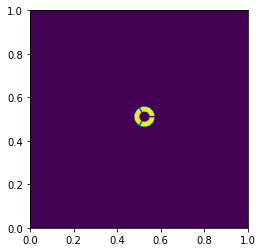

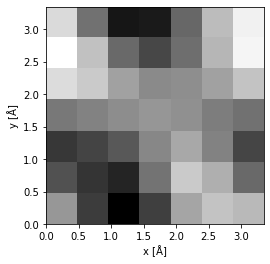

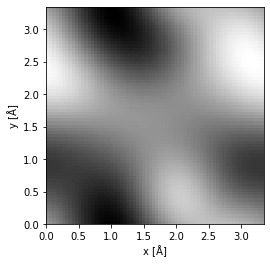

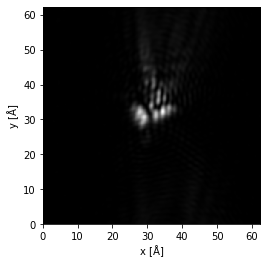

In [30]:
aperture = DeviatedAnularAperture(aperture_angle=semiangle_cutoff,x_0=delta.real*1e3,y_0=delta.imag*1e3,inner_aperture_angle=semiangle_cutoff/2,spoke_thickness=spoke_thickness,spokes=spokes)
#aperture = DeviatedAperture(aperture_angle=semiangle_cutoff,x_0=delta.real*1e3,y_0=delta.imag*1e3)

probe_deviated = Probe(aperture=aperture, energy=energy, semiangle_cutoff=semiangle_cutoff+np.absolute(delta), rolloff=0.1)#, angular_spread=angular_spread,focal_spread=focal_spread)
probe_deviated.grid.match(potential)
imshow(np.absolute(fft_shift(probe_deviated.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,gpts/2]))),extent=(0,1,0,1))

_, _, aberations_dict_deviated = get_coeffs(C1=-defocus_0*1e-10,A1=A1,C3=C3,B2=(0+0j)*1e-6,A2=(0+0j)*30e-6) #arguments in [m] and returns in angstrem
probe_deviated.ctf.set_parameters(aberations_dict_deviated)
#probe_deviated.ctf.set_parameters({'phi12': -3.1415/4})
print(probe_deviated.ctf.parameters)

start = np.array([0,0]) # it is supposed to be in angstrems
end = np.array((potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1]))
gridscan = GridScan(start=start, end=end, sampling=probe_deviated.ctf.nyquist_sampling * .9)

measurement_deviated = probe_deviated.scan(gridscan, detector, potential)
measurement_deviated.integrate(50,80).show()
measurement_deviated.integrate(50,80).interpolate(0.05).show()
probe_deviated.show()

#print(np.shape(measurement_deviated.array))

In [31]:
%matplotlib qt
imshow(np.absolute(fft_shift(probe_deviated.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,gpts/2]))),extent=(0,1,0,1))


In [32]:
#Showing probes via abtem methods

In [33]:
%matplotlib qt
probe_deviated.show(log_scale=False)
probe_transformed.show(log_scale=False)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fe665656fd0>)

In [34]:
#Shifting transformed probe to see that it is simmilar to deviated one

In [35]:
#%matplotlib qt
image_deviated=(np.absolute(fft_shift(probe_deviated.build().intensity().array,np.array([0,0]))))[0]
image_transformed=(np.absolute(fft_shift(probe_transformed.build().intensity().array,C01/probe_transformed.grid.sampling)))[0]
plt.figure()

extent=np.array(probe_deviated.grid.gpts)*probe_deviated.grid.sampling
imshow(np.swapaxes(image_deviated,0,1),extent=(0,extent[0],0,extent[1]))
plt.figure()
imshow(np.swapaxes(image_transformed,0,1),extent=(0,extent[0],0,extent[1]))
plt.figure()
imshow(np.log(np.swapaxes(np.abs(image_transformed-image_deviated)/image_deviated,0,1)),extent=(0,extent[0],0,extent[1]))
plt.colorbar()
plt.show()

In [36]:
#Showing aperture

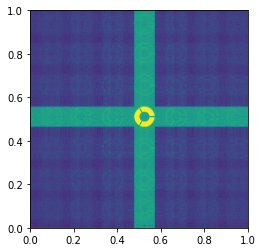

In [37]:
%matplotlib inline
values=probe_deviated.ctf.evaluate_aperture(alpha,phi)
image=np.log(np.absolute(fft_shift(values,np.array([gpts/2,gpts/2]))))
imshow(image,extent=(0,1,0,1))

In [38]:
#Show azimuthal angle phi

Text(0, 0.5, 'alpha_y')

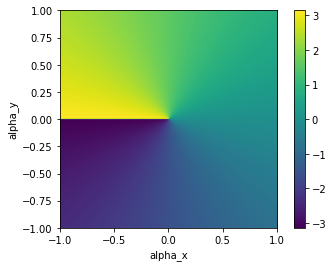

In [39]:
imshow(np.real(fft_shift(phi,np.array([gpts/2,-gpts/2]))),extent=(-1,1,-1,1)); plt.colorbar()
plt.xlabel("alpha_x")
plt.ylabel("alpha_y")

#imshow(np.absolute(fft_shift(probe_deviated.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,-gpts/2]))),extent=(0,1,0,1))
#imshow(np.absolute(probe_deviated.ctf.evaluate_aperture(alpha,phi)),extent=(0,1,0,1))

In [40]:
#Showing probe without np.swapaxes(...,0,1) and only with mirroring along axis=0

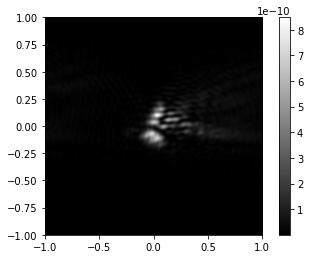

In [41]:
imshow(np.real(probe_deviated.build().intensity().array[0]),cmap="gray",extent=(-1,1,-1,1)); plt.colorbar()

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fe662b69670>)

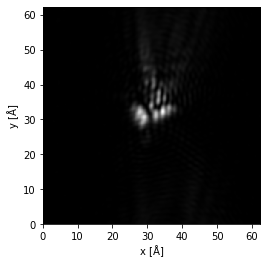

In [42]:
probe_deviated.show()

In [43]:
#Croscorrelation of obtained probes via deviation and transformation and their relative simillarity

integrated squared probe (deviated) p_d = 4.1132624e-16
maximal value in convolution p_c =  4.1555267e-16
fraction p_c/p_d =  1.0102751


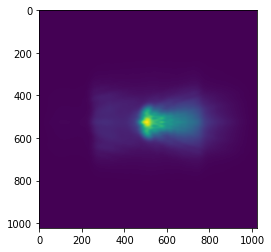

In [44]:
from scipy  import signal
p_deviated = np.abs(probe_deviated.build().intensity().array[0])
p_transformed = np.abs(probe_transformed.build().intensity().array[0])

p_deviated_sq = signal.fftconvolve(p_deviated,p_deviated[::-1]).max()

print("integrated squared probe (deviated) p_d =",p_deviated_sq)

conv = signal.fftconvolve(p_deviated,p_transformed[::-1])

imshow(conv)

print("maximal value in convolution p_c = ",conv.max())

print("fraction p_c/p_d = ",conv.max()/p_deviated_sq)